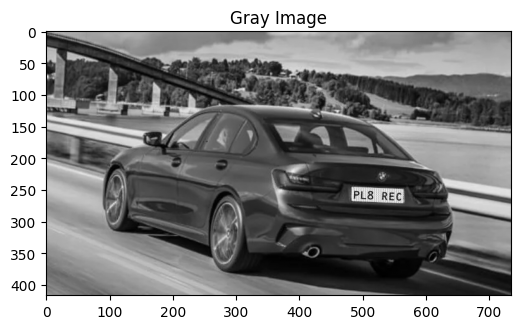

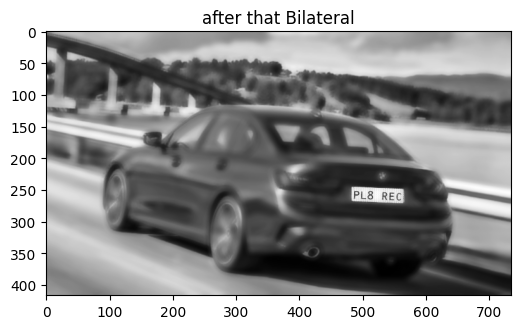

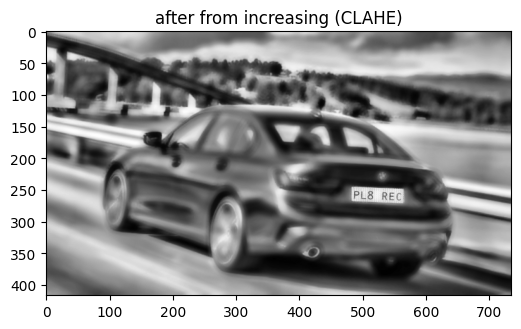

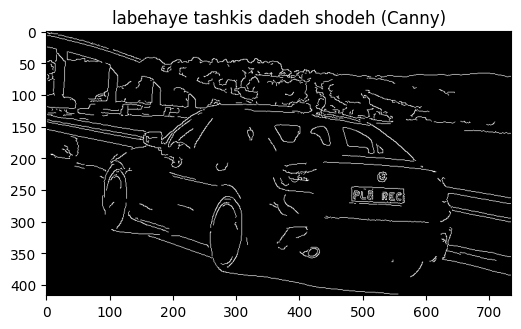

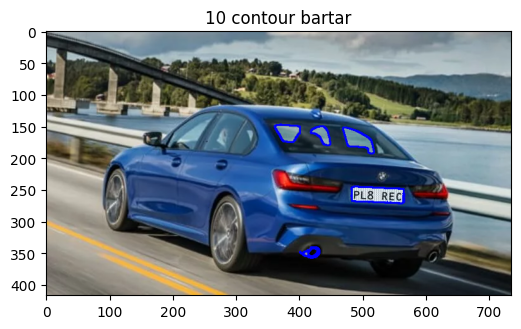

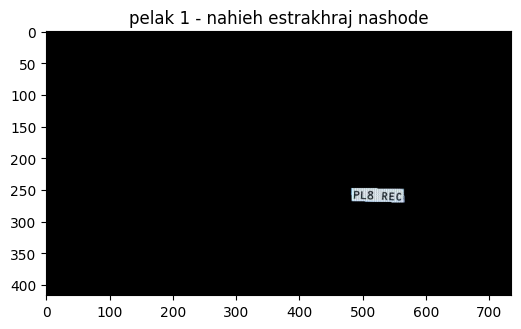

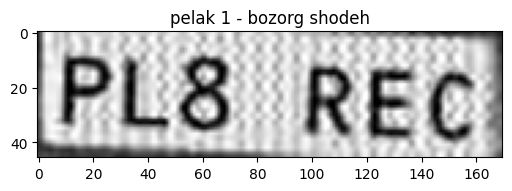

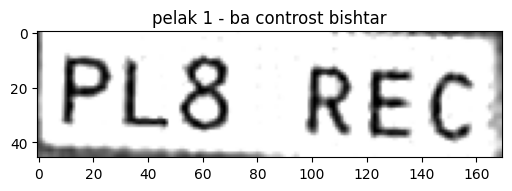

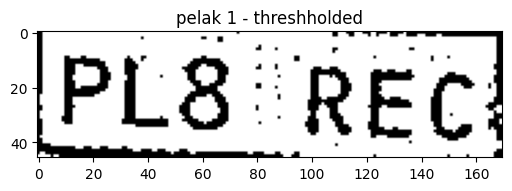

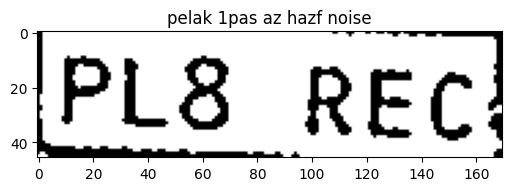

Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



نتایج تشخیص متن فارسی برای پلاک 1:
متن: PL8 REC - اطمینان: 0.98

متن نهایی پلاک 1: PL8 REC


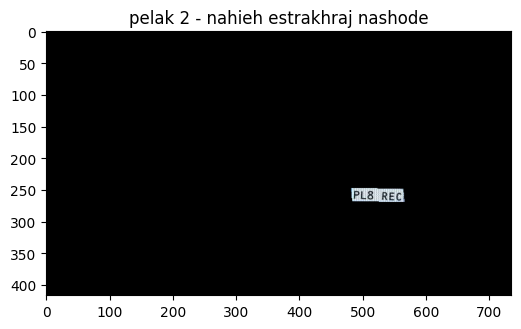

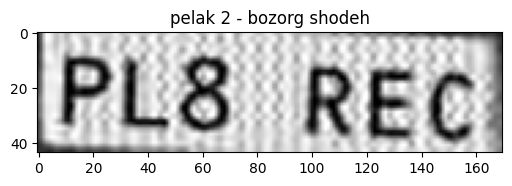

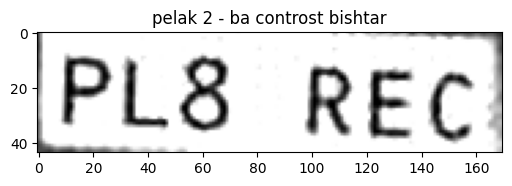

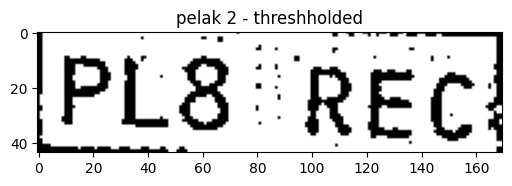

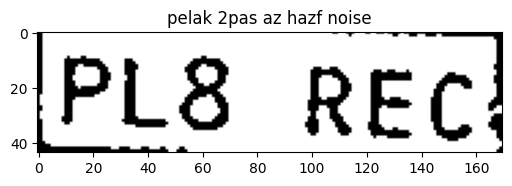

Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



نتایج تشخیص متن فارسی برای پلاک 2:
متن: PL8 REC: - اطمینان: 0.83

متن نهایی پلاک 2: PL8 REC:


In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import imutils
import easyocr

# خواندن تصویر اصلی
car_img = cv.imread('C:/Users/koosha/Desktop/ANPR-number-plate-recognition-camera-video-stream.webp')
car_img_gray = cv.cvtColor(car_img, cv.COLOR_BGR2GRAY)

# نمایش تصویر خاکستری اولیه
plt.figure(figsize=(6, 4))
plt.imshow(car_img_gray, cmap='gray')
plt.title('Gray Image')
plt.show()

# پیش‌پردازش تصویر
# 1. کاهش نویز با فیلتر بیلاترال
bilateral_filtered = cv.bilateralFilter(car_img_gray, 15, 75, 75)
plt.figure(figsize=(6, 4))
plt.imshow(bilateral_filtered, cmap='gray')
plt.title('after that Bilateral')
plt.show()

# 2. افزایش کنتراست با CLAHE
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
contrast_enhanced = clahe.apply(bilateral_filtered)
plt.figure(figsize=(6, 4))
plt.imshow(contrast_enhanced, cmap='gray')
plt.title('after from increasing (CLAHE)')
plt.show()

# 3. تشخیص لبه‌ها با Canny
edges = cv.Canny(contrast_enhanced, 100, 150)
plt.figure(figsize=(6, 4))
plt.imshow(edges, cmap='gray')
plt.title('labehaye tashkis dadeh shodeh (Canny)')
plt.show()

# یافتن کانتورها
contours = cv.findContours(edges.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_refined = imutils.grab_contours(contours)
contours_sorted = sorted(contours_refined, key=cv.contourArea, reverse=True)[:10]

# رسم کانتورهای انتخاب شده روی تصویر
contour_img = car_img.copy()
cv.drawContours(contour_img, contours_sorted, -1, (255, 0, 0), 2)
plt.figure(figsize=(6, 4))
plt.imshow(cv.cvtColor(contour_img, cv.COLOR_BGR2RGB))
plt.title('10 contour bartar')
plt.show()

# یافتن پلاک‌ها (مستطیل‌ها)
plate_locations = []
for contour in contours_sorted:
    perimeter = cv.arcLength(contour, True)
    contour_approx = cv.approxPolyDP(contour, 0.02 * perimeter, True)
    if len(contour_approx) == 4:
        plate_locations.append(contour_approx)
        if len(plate_locations) == 2:
            break

if len(plate_locations) == 0:
    raise Exception("هیچ پلاکی پیدا نشد!")

# پردازش هر پلاک
for i, plate_location in enumerate(plate_locations):
    plate_mask = np.zeros(car_img.shape[:2], np.uint8)
    cv.drawContours(plate_mask, [plate_location], -1, 255, -1)
    plate_img = cv.bitwise_and(car_img, car_img, mask=plate_mask)

    # نمایش پلاک استخراج‌شده
    plt.figure(figsize=(6, 4))
    plt.imshow(cv.cvtColor(plate_img, cv.COLOR_BGR2RGB))
    plt.title(f'pelak {i+1} - nahieh estrakhraj nashode')
    plt.show()

    (x, y) = np.where(plate_mask == 255)
    (x1, y1), (x2, y2) = (np.min(x), np.min(y)), (np.max(x), np.max(y))
    cropped_img = car_img_gray[x1:x2+1, y1:y2+1]

    # مرحله 1: افزایش اندازه
    scale_factor = 2
    cropped_img = cv.resize(cropped_img, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_CUBIC)
    plt.figure(figsize=(6, 4))
    plt.imshow(cropped_img, cmap='gray')
    plt.title(f'pelak {i+1} - bozorg shodeh')
    plt.show()

    # مرحله 2: افزایش کنتراست
    cropped_img = cv.convertScaleAbs(cropped_img, alpha=1.5, beta=0)
    plt.figure(figsize=(6, 4))
    plt.imshow(cropped_img, cmap='gray')
    plt.title(f'pelak {i+1} - ba controst bishtar')
    plt.show()

    # مرحله 3: آستانه‌گذاری تطبیقی
    cropped_img = cv.adaptiveThreshold(cropped_img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv.THRESH_BINARY, 11, 2)
    plt.figure(figsize=(6, 4))
    plt.imshow(cropped_img, cmap='gray')
    plt.title(f'pelak {i+1} - threshholded')
    plt.show()

    # مرحله 4: کاهش نویز
    kernel = np.ones((2, 2), np.uint8)
    cropped_img = cv.morphologyEx(cropped_img, cv.MORPH_OPEN, kernel)
    cropped_img = cv.medianBlur(cropped_img, 3)
    plt.figure(figsize=(6, 4))
    plt.imshow(cropped_img, cmap='gray')
    plt.title(f'pelak {i+1}pas az hazf noise')
    plt.show()

    # ذخیره تصویر پردازش‌شده
    cv.imwrite(f'C:/Users/koosha/Desktop/processed_plate_{i+1}.jpg', cropped_img)

    # OCR
    reader_fa = easyocr.Reader(['fa'], gpu=False)
    reader_en = easyocr.Reader(['en'], gpu=False)

    plate_info_fa = reader_fa.readtext(cropped_img,
                                       detail=1,
                                       paragraph=False,
                                       contrast_ths=0.1,
                                       adjust_contrast=0.5,
                                       width_ths=0.7,
                                       decoder='beamsearch',
                                       beamWidth=10)

    plate_info_en = reader_en.readtext(cropped_img,
                                       detail=1,
                                       paragraph=False,
                                       contrast_ths=0.1,
                                       adjust_contrast=0.5,
                                       width_ths=0.7,
                                       decoder='beamsearch',
                                       beamWidth=10)

    print(f"\nنتایج تشخیص متن فارسی برای پلاک {i+1}:")
    for result in plate_info_en:
        print(f"متن: {result[1]} - اطمینان: {result[2]:.2f}")

    plate_text = ""
    if plate_info_en:
        plate_text += " ".join([res[1] for res in plate_info_en]) + " "

    print(f"\nمتن نهایی پلاک {i+1}: {plate_text.strip()}")
